In [73]:
import os
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

In [5]:
PATH = "./"
EXCEL_PATH = []
for i in os.listdir(PATH):
    if i.endswith(".xlsx"):
        EXCEL_PATH.append(
                os.path.join(
                PATH, i
            )
        )

In [28]:
EXCEL_PATH[1]

'./5m_20derajat_7pin.xlsx'

In [45]:
a = {"a":[2,3,4]}
a["a"][0]

2

In [118]:
class KalmanFilter(object):
    def __init__(self, dt, u, std_acc, std_meas):
        self.dt = dt
        self.u = u
        self.std_acc = std_acc
        self.A = np.matrix([[1, self.dt],
                            [0, 1]])
        self.B = np.matrix([[(self.dt**2)/2], [self.dt]]) 
        self.H = np.matrix([[1,0]])
        self.Q = np.matrix([[(self.dt**4)/4, (self.dt**3)/2],
                            [(self.dt**3)/2, self.dt**2]]) * self.std_acc**2
        self.R = std_meas**2
        self.P = np.eye(self.A.shape[1])
        self.x = np.matrix([[0],[0]])
    
    def predict(self):
        # Ref :Eq.(9) and Eq.(10)
        # Update time state
        self.x = np.dot(self.A, self.x) + np.dot(self.B, self.u)
        # Calculate error covariance
        # P= A*P*A' + Q
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
        return self.x   
    
    def update(self, z):
        # Ref :Eq.(11) , Eq.(11) and Eq.(13)
        # S = H*P*H'+R
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R
        # Calculate the Kalman Gain
        # K = P * H'* inv(H*P*H'+R)
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))  # Eq.(11)
        self.x = np.round(self.x + np.dot(K, (z - np.dot(self.H, self.x))))  # Eq.(12)
        I = np.eye(self.H.shape[1])
        self.P = (I - (K * self.H)) * self.P  # Eq.(13)

def moving_average(arr, x):
    i = 1
    # Initialize an empty list to
    # store exponential moving averages
    moving_averages = []
    
    # Insert first exponential average in the list
    moving_averages.append(arr[0])
    
    # Loop through the array elements
    while i < len(arr):
    
        # Calculate the exponential
        # average by using the formula
        window_average = round((x*arr[i])+
                            (1-x)*moving_averages[-1], 2)
        
        # Store the cumulative average
        # of current window in moving average list
        moving_averages.append(window_average)
        
        # Shift window to right by one position
        i += 1
    
    print(moving_averages)
    return moving_averages


In [150]:
FOLDER_INDEX = 0
THRESH_ATAS = 600
THRESH_BAWAH = 230
SETPOINT = 27

df = pd.read_excel(EXCEL_PATH[0])
PIN_NAME = ['Channel-17', 'Channel-18', 'Channel-19', 'Channel-20', 'Channel-21', 'Channel-22', 'Channel-23']
SUM_DATA = {}
SUM_DATA["All"] = []
temp = 0
OFFSET = []

for i in PIN_NAME:
    DEVIATION = SETPOINT - df[i][THRESH_BAWAH]
    OFFSET.append(DEVIATION)
    SUM_DATA[i] = (df[i][THRESH_BAWAH:THRESH_ATAS] + DEVIATION).to_list()

for i in range(0, THRESH_ATAS-THRESH_BAWAH):
    for j in SUM_DATA.keys():
        if j != "All":
            temp += SUM_DATA[j][i]
        else:
            pass
        
    SUM_DATA["All"].append(temp/len(PIN_NAME))
    temp = 0



In [136]:
dt = 1
t = len(SUM_DATA["All"])
# Define a model track

u= 0.1
std_acc = 0.1     # we assume that the standard deviation of the acceleration is 0.25 (m/s^2)
std_meas = 0.23   # and standard deviation of the measurement is 1.2 (m)
# create KalmanFilter object
kf = KalmanFilter(dt, u, std_acc, std_meas)
predictions = []
measurements = []
for x in SUM_DATA["All"]:
    # Mesurement
    z = kf.H * x 
    measurements.append(z.item(0))
    predictions.append(kf.predict()[0])
    kf.update(z.item(0))

In [143]:
DEVIATION

8.399999999999999

Mean : 27.151235521235524, std : 0.233574271094168


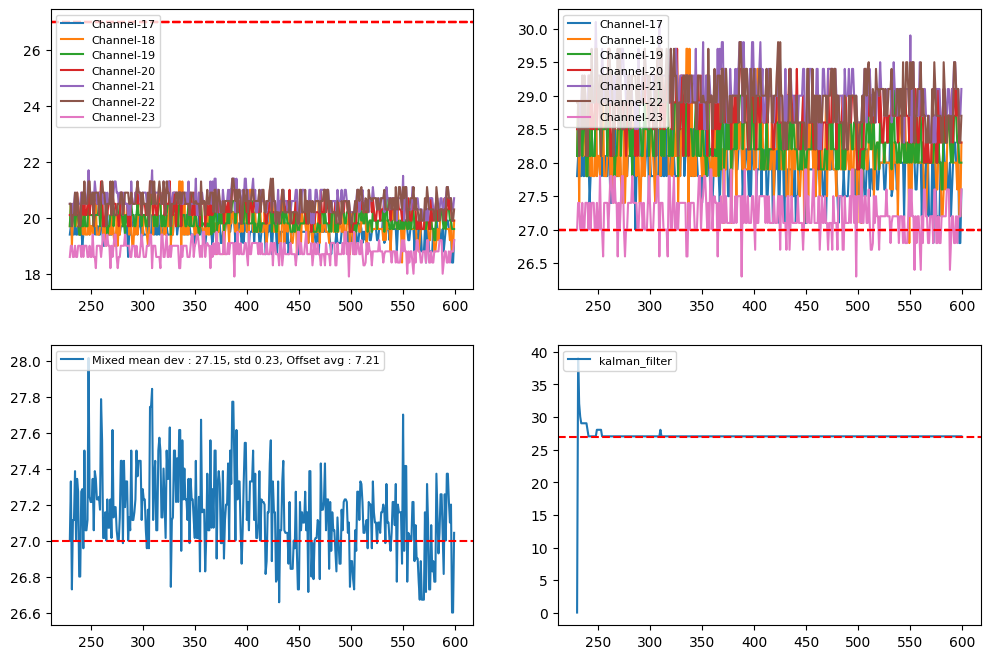

In [152]:
fig, ax = plt.subplots(2,2,figsize=(12,8))
for i in PIN_NAME:
    ax[0][0].plot(df.index[THRESH_BAWAH:THRESH_ATAS], df[i][THRESH_BAWAH:THRESH_ATAS], label=i)
    ax[0][0].axhline(27, 0, 600, linestyle='--', color='r')
    ax[0][1].plot(df.index[THRESH_BAWAH:THRESH_ATAS], df[i][THRESH_BAWAH:THRESH_ATAS] + DEVIATION, label=i)
    ax[0][1].axhline(27, 0, 600, linestyle='--', color='r')

a = SUM_DATA["All"]
print(f"Mean : {np.mean(np.array(a))}, std : {np.std(np.array(a))}")
ax[1][0].plot(df.index[THRESH_BAWAH:THRESH_ATAS], SUM_DATA["All"], label=f"Mixed mean dev : {round(np.mean(np.array(a)), 2)}, std {round(np.std(np.array(a)), 2)}, Offset avg : {round(sum(OFFSET)/len(OFFSET),2)}")
ax[1][0].axhline(27, 0, 600, linestyle='--', color='r')    

ax[1][1].plot(df.index[THRESH_BAWAH:THRESH_ATAS], np.squeeze(predictions), label='kalman_filter')
ax[1][1].axhline(27, 0, 600, linestyle='--', color='r')    

ax[0][0].legend(fontsize=8, loc="upper left")
ax[0][1].legend(fontsize=8, loc="upper left")
ax[1][0].legend(fontsize=8, loc="upper left")
ax[1][1].legend(fontsize=8, loc="upper left")
plt.savefig('a.png')
plt.show()